In [188]:
import pandas as pd
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from bcb import sgs
import talib as tb
from sklearn.ensemble import StackingClassifier
import time
import xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import classification_report
import skfuzzy as fuzz
from skfuzzy import control as ctl



In [189]:
#conexão com o servidor
pytrends = TrendReq(hl='en-US', tz=360)

#lista com palavra chave
kw_list = ['bitcoin']

#download google trends
pytrends.build_payload(kw_list, cat=0, timeframe='2015-07-01 2023-08-14', geo='',gprop='' )
teste = pytrends.interest_over_time()

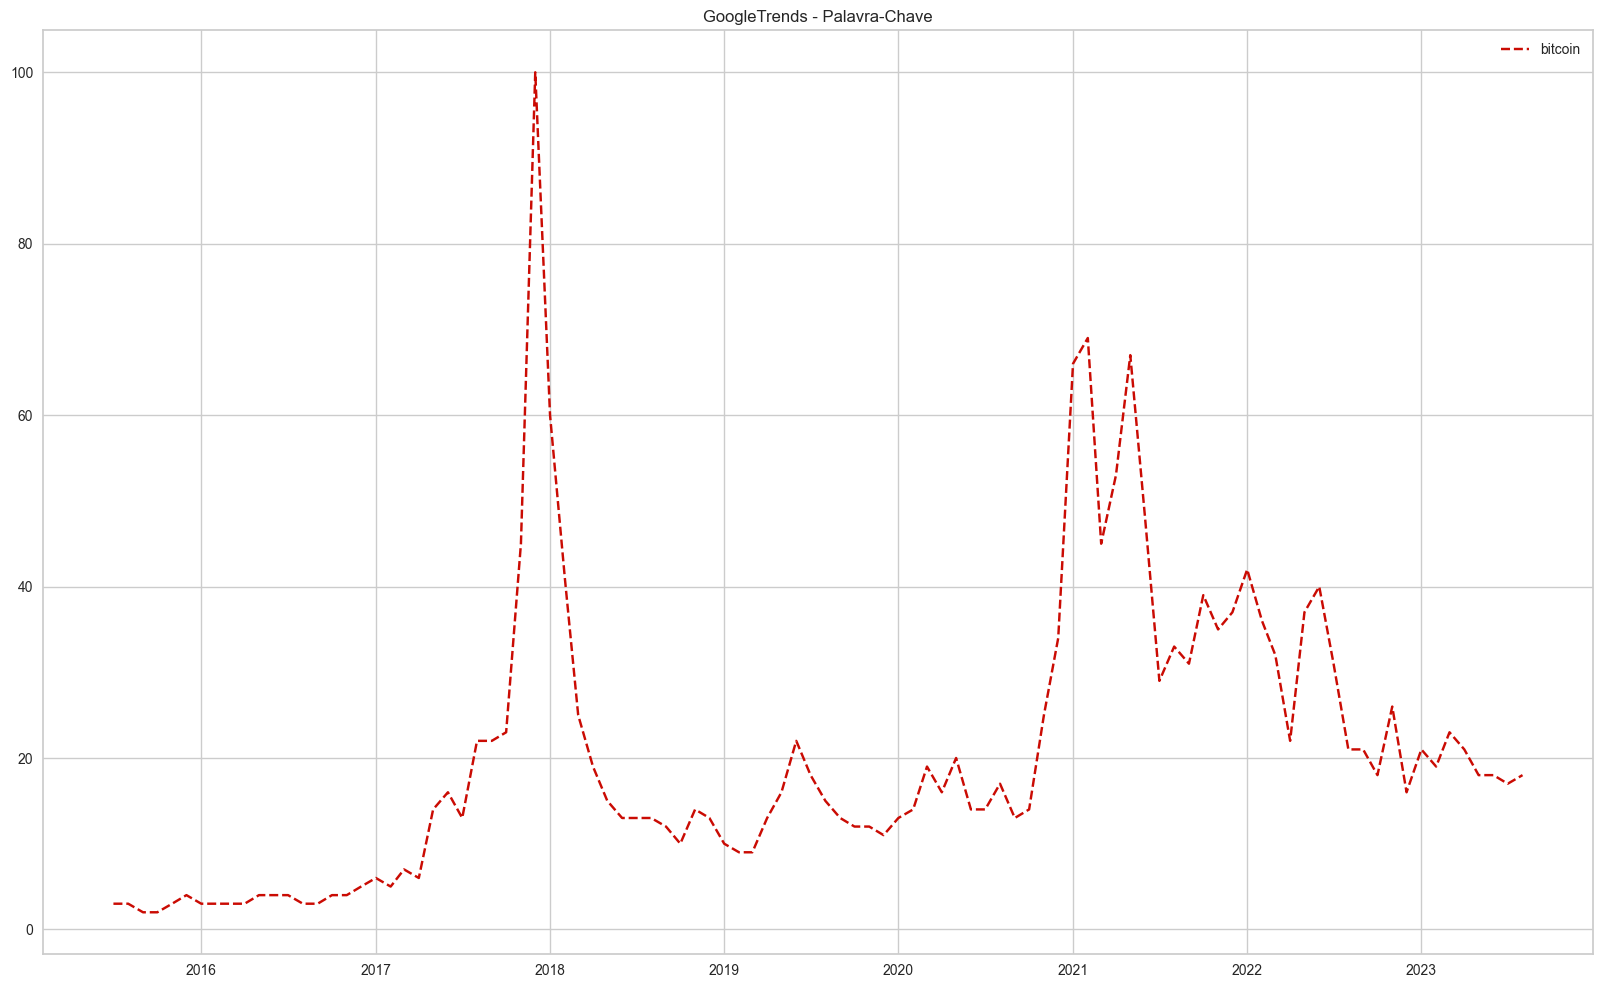

In [190]:
figura = plt.figure(figsize=(20,12))
ax1=plt.subplot(111)
plt.title('GoogleTrends - Palavra-Chave')
#formação da figura
ax1.plot(teste[kw_list], '--r')

plt.legend(kw_list, loc='upper right', shadow=True)

In [191]:
ativos = ["BTC-USD"]
df = yf.download(ativos, start="2015-07-01")


[*********************100%***********************]  1 of 1 completed


In [192]:
cdi = sgs.get({'CDI':12}, start='1970-01-01')
ipca = sgs.get({'IPCA':433}, start='2005-01-01')



In [193]:
df["ipca"] = ipca


In [194]:
df["ipca"] = df["ipca"].fillna(0)

In [195]:
valor = None
for i in range(len(df)):
    if(df["ipca"].iloc[i] != 0):
        valor = df["ipca"].iloc[i]
    elif(df["ipca"].iloc[i] == 0):
        df["ipca"].iloc[i] = valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [196]:
df["cdi"] = cdi/100

In [197]:
df = df.dropna()

In [198]:
df['trendbtc'] = teste["bitcoin"]/100

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [199]:
df["trendbtc"] = df["trendbtc"].fillna(0)


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [200]:
valor = None
for i in range(len(df)):
    if(df["trendbtc"].iloc[i] != 0):
        valor = df["trendbtc"].iloc[i]
    elif(df["trendbtc"].iloc[i] == 0):
        df["trendbtc"].iloc[i] = valor 

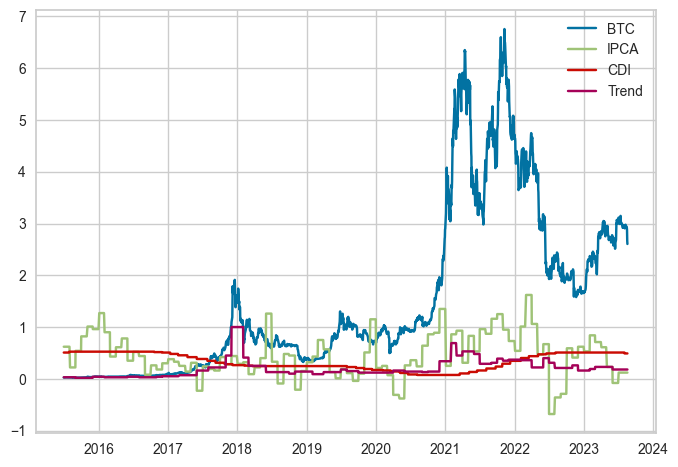

In [201]:
plt.plot(df.index, df["Adj Close"]/10000, label="BTC")
plt.plot(df.index, df["ipca"], label="IPCA")
plt.plot(df.index, df["cdi"]*1000, label="CDI")
plt.plot(df.index, df["trendbtc"], label="Trend")
plt.legend()

In [202]:
vetor = list([])
for i in range(len(df)-1):
    if (i == len(df)):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  <  df["Adj Close"].iloc[i]):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  >  df["Adj Close"].iloc[i]): 
        vetor.append(1)
    else:
        vetor.append(0)

In [203]:
df = df.drop(df.index[-1])
df["signal"] = vetor


In [204]:
df = df.dropna()

In [205]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [206]:
df_norm = scaler.fit_transform(df)
df_norm = pd.DataFrame(df_norm)
df_norm.columns = df.columns

In [207]:
df_norm = df_norm.set_index(df.index) #= df_norm.set_index(df_norm["index"])

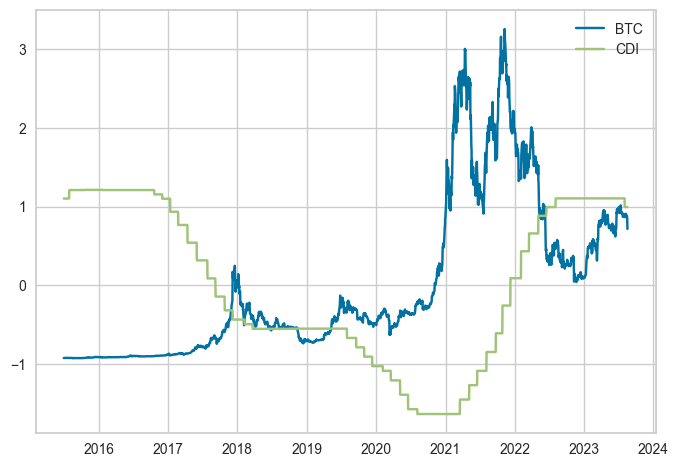

In [208]:
plt.plot(df_norm.index, df_norm["Adj Close"], label="BTC")
plt.plot(df_norm.index, df_norm["cdi"], label="CDI")
plt.legend()

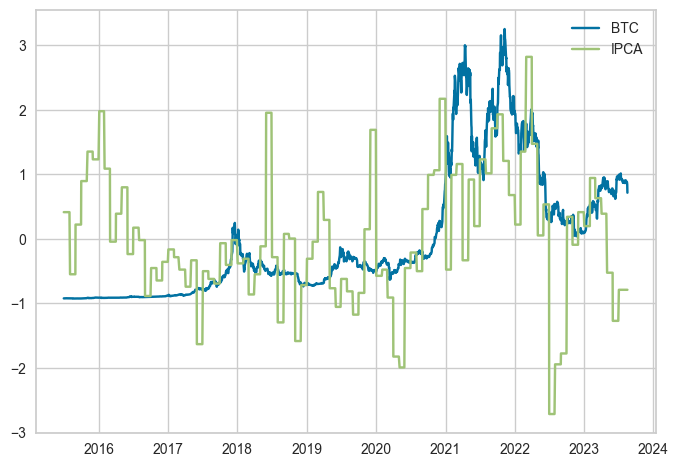

In [209]:
plt.plot(df_norm.index, df_norm["Adj Close"], label="BTC")
plt.plot(df_norm.index, df_norm["ipca"], label="IPCA")
plt.legend()

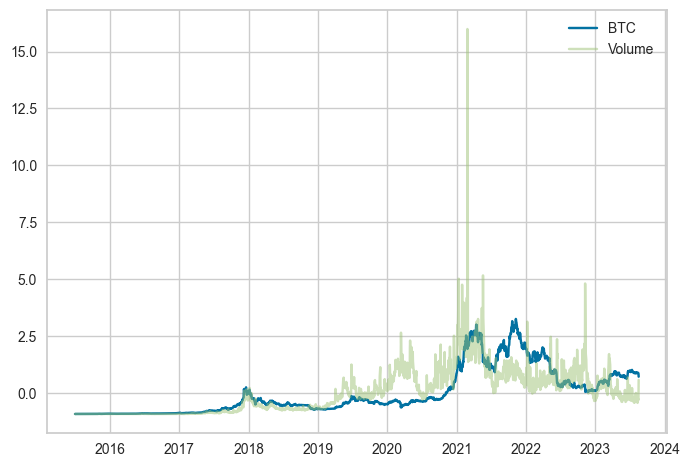

In [210]:
plt.plot(df_norm.index, df_norm["Adj Close"], label="BTC")
plt.plot(df_norm.index, df_norm["Volume"],alpha=0.5, label="Volume")
plt.legend()

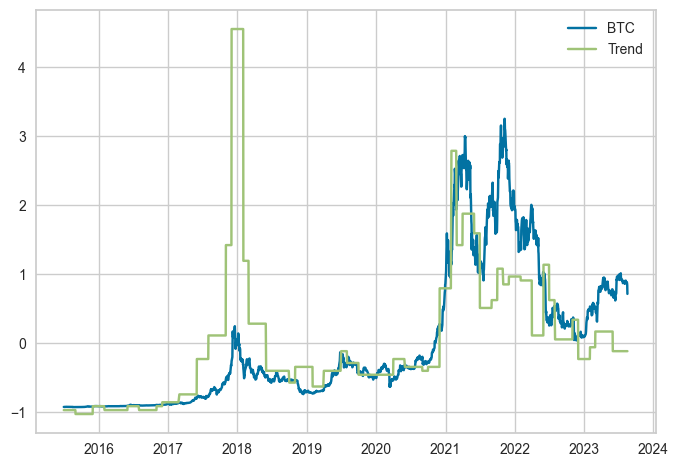

In [211]:
plt.plot(df_norm.index, df_norm["Adj Close"], label="BTC")
plt.plot(df_norm.index, df_norm["trendbtc"], label="Trend")
plt.legend()

In [212]:
df_norm["signal"] = df["signal"]

In [213]:
Y = df_norm["signal"]
X = df_norm.loc[:, (df_norm.columns != "signal")&(df_norm.columns != "Date")&(df_norm.columns != "Open")&(df_norm.columns != "Close")&(df_norm.columns != "High")&(df_norm.columns != "Low")]#&(df_norm.columns != "Volume")&(df_norm.columns != "k")&(df_norm.columns != "Close")&(df_norm.columns != "Low")]

X = pd.DataFrame(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [214]:

logmodel = LogisticRegression()
logmodel.fit(x_train,y_train)
predictionslogtest = logmodel.predict(x_test)
print(classification_report(y_test,predictionslogtest))


              precision    recall  f1-score   support

           0       0.56      0.20      0.29       296
           1       0.53      0.85      0.66       317

    accuracy                           0.54       613
   macro avg       0.54      0.53      0.47       613
weighted avg       0.54      0.54      0.48       613



c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\yellowbrick\model_selection\importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


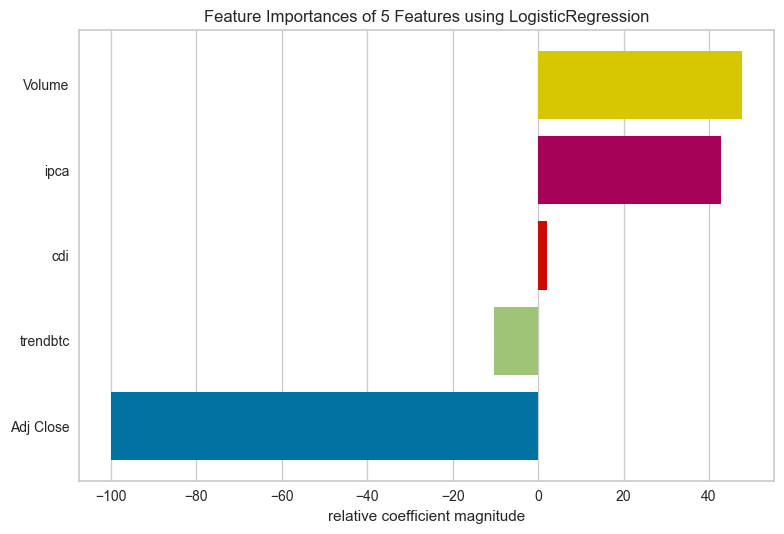

<AxesSubplot:title={'center':'Feature Importances of 5 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [215]:
viz = FeatureImportances(logmodel)
fig, ax = plt.subplots()
viz = FeatureImportances(logmodel, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

In [216]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
predictdttest = dt.predict(x_test)
print(classification_report(y_test,predictdttest))

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       296
           1       0.56      0.59      0.58       317

    accuracy                           0.55       613
   macro avg       0.55      0.55      0.55       613
weighted avg       0.55      0.55      0.55       613



c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


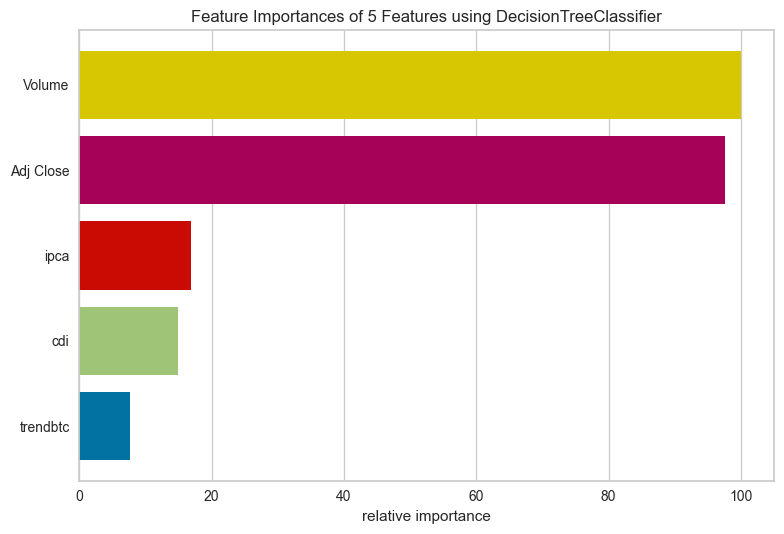

<AxesSubplot:title={'center':'Feature Importances of 5 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [217]:
viz = FeatureImportances(dt)
fig, ax = plt.subplots()
viz = FeatureImportances(dt, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

In [218]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
predictrftest = rf.predict(x_test)
print(classification_report(y_test, predictrftest))


              precision    recall  f1-score   support

           0       0.54      0.52      0.53       296
           1       0.57      0.60      0.58       317

    accuracy                           0.56       613
   macro avg       0.56      0.56      0.56       613
weighted avg       0.56      0.56      0.56       613



c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


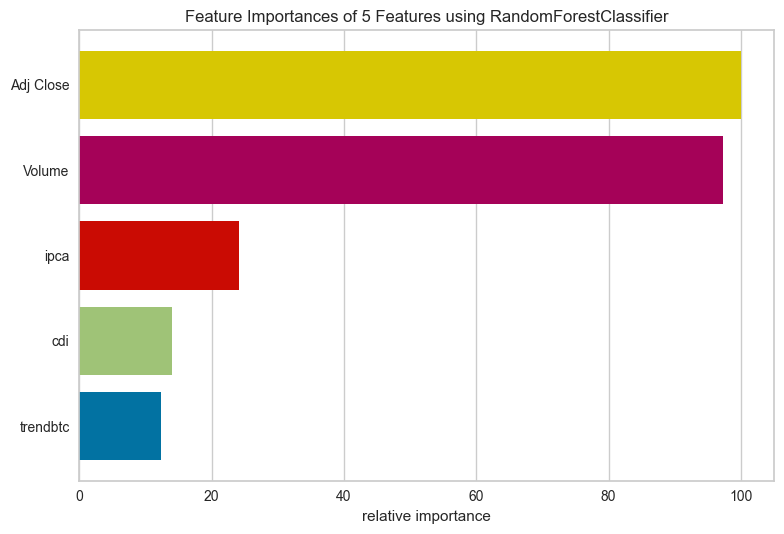

<AxesSubplot:title={'center':'Feature Importances of 5 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [219]:
viz = FeatureImportances(rf)
fig, ax = plt.subplots()
viz = FeatureImportances(rf, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

    logica fuzzy

In [220]:
df_norm["Volume"].max()

15.988128072381059

In [221]:
df_norm.corr()["Adj Close"]

Open         0.998468
High         0.999343
Low          0.999231
Close        1.000000
Adj Close    1.000000
Volume       0.679440
ipca         0.345555
cdi         -0.247466
trendbtc     0.600188
signal      -0.062574
Name: Adj Close, dtype: float64

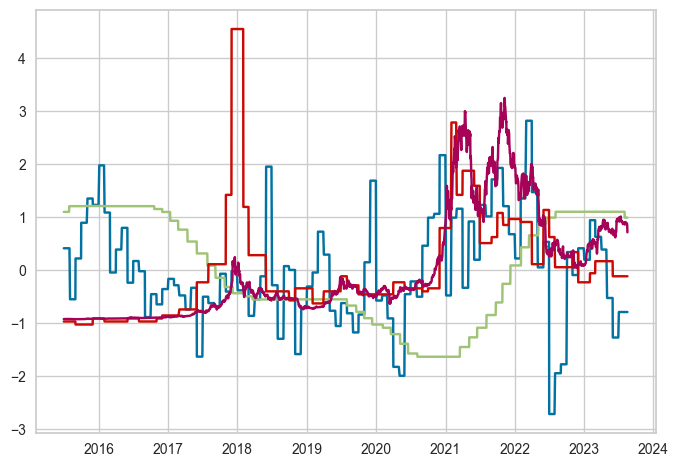

In [222]:
plt.plot(df_norm.index, df_norm["ipca"])
plt.plot(df_norm.index, df_norm["cdi"])
plt.plot(df_norm.index, df_norm["trendbtc"])


plt.plot(df_norm.index, df_norm["Adj Close"])


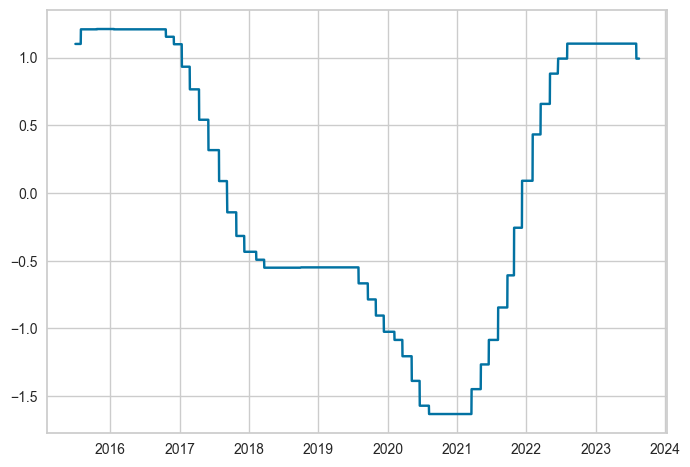

In [223]:
plt.plot(df_norm.index, df_norm["cdi"])

In [224]:
dfteste = df_norm

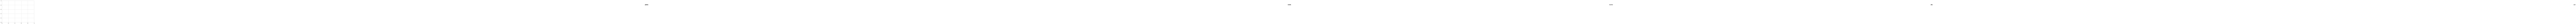

In [225]:
#eixo das abscissas para as fun, pertinencia
palavra=ctl.Antecedent(np.arange(0,100,1),'bitcoin')
volume=ctl.Antecedent(np.arange(0,16.096186192349908,2.5),'volume')
cdi=ctl.Antecedent(np.arange(-1.5,1.65,0.5),'cdi')
ipca=ctl.Antecedent(np.arange(-2.15,2.58,0.10),'ipca')

decisao = ctl.Consequent(np.arange(0,100,1),'decisao')

#Função pertinencia para palavra
palavra['pouca'] = fuzz.gaussmf(palavra.universe,0.2,0.3)
palavra['media'] = fuzz.gaussmf(palavra.universe,1,0.3)
palavra['alta'] = fuzz.gaussmf(palavra.universe,1.75,0.3)
# palavra.view()
plt.text(x=20,y=0.8,s='pouca',fontsize=16, weight='bold')
plt.text(x=40,y=0.8,s='media',fontsize=16, weight='bold')
plt.text(x=60,y=0.8,s='alta',fontsize=16, weight='bold')

# #Função pertinencia para volume
volume['pouca'] = fuzz.gaussmf(volume.universe,-1,0.4)
volume['media'] = fuzz.gaussmf(volume.universe,-0.2,0.4)
volume['alta'] = fuzz.gaussmf(volume.universe,0.5,0.4)
#volume.view()
plt.text(x=20,y=0.8,s='pouca',fontsize=16, weight='bold')
plt.text(x=40,y=0.8,s='media',fontsize=16, weight='bold')
plt.text(x=60,y=0.8,s='alta',fontsize=16, weight='bold')

#Função pertinencia para cdi
cdi['pouca'] = fuzz.gaussmf(cdi.universe,-1,0.30)
cdi['media'] = fuzz.gaussmf(cdi.universe,0,0.30)
cdi['alta'] = fuzz.gaussmf(cdi.universe,1,0.30)
# cdi.view()
plt.text(x=20,y=0.8,s='pouca',fontsize=16, weight='bold')
plt.text(x=40,y=0.8,s='media',fontsize=16, weight='bold')
plt.text(x=60,y=0.8,s='alta',fontsize=16, weight='bold')

#Função pertinencia para ipca
ipca['pouca'] = fuzz.gaussmf(ipca.universe,-1.2,0.6)
ipca['media'] = fuzz.gaussmf(ipca.universe,0,0.6)
ipca['alta'] = fuzz.gaussmf(ipca.universe,1.2,0.6)
# ipca.view()
plt.text(x=20,y=0.8,s='pouca',fontsize=16, weight='bold')
plt.text(x=40,y=0.8,s='media',fontsize=16, weight='bold')
plt.text(x=60,y=0.8,s='alta',fontsize=16, weight='bold')


#Função pertinencia para decisao
decisao['subir'] = fuzz.gaussmf(decisao.universe,20,10)
decisao['manter'] = fuzz.gaussmf(decisao.universe,50,10)
decisao['cair'] = fuzz.gaussmf(decisao.universe,80,10)
# decisao.view()
plt.text(x=20,y=0.8,s='subir',fontsize=16, weight='bold')
plt.text(x=50,y=0.8,s='manter',fontsize=16, weight='bold')
plt.text(x=80,y=0.8,s='cair',fontsize=16, weight='bold')

plt.show()

#Regras da lógica fuzzy
regra1=ctl.Rule((palavra["alta"] or palavra["media"]) & ipca['pouca'] & cdi["pouca"]&volume["alta"], decisao['subir'])
regra2=ctl.Rule((palavra["pouca"] or palavra["media"]) & ipca['pouca'] & cdi["pouca"] & volume["alta"], decisao['subir'])
regra4=ctl.Rule(palavra['pouca'] & ipca['alta'] & (cdi["media"] or cdi["alta"]) & volume["alta"], decisao['cair'])
regra5=ctl.Rule(palavra['media'] & ipca['media'] & cdi["media"] & (volume["media"] or volume["pouca"]), decisao['manter'])
# regra4=ctl.Rule((palavra["alta"] or palavra["media"]) & ipca['pouca'] & (cdi["pouca"] or cdi["media"]), decisao['subir'])
# regra5=ctl.Rule((palavra["alta"]or palavra["media"]) & ipca["pouca"] & cdi["media"], decisao['subir'])



#Sistema de criação de controle/simulação
dec_ctl = ctl.ControlSystem([regra1,regra2,regra4,regra5])
dec = ctl.ControlSystemSimulation(dec_ctl)

#função de cálculo para a desfuzzificação
def IndFzy(entrada):
    #entrada
    dec.input['bitcoin']=entrada[0]
    dec.input['volume']=entrada[1]
    dec.input['cdi']=entrada[2]
    dec.input['ipca']=entrada[3]

    #saída fuzzy
    dec.compute()
    return(dec.output['decisao'])


In [226]:

dfteste = df_norm
mval = np.zeros((len(dfteste['Close']),3))
for i in range(len(dfteste)):
    res1 = IndFzy([dfteste['trendbtc'].values[i],dfteste['Volume'].values[i],dfteste['cdi'].values[i],dfteste['ipca'].values[i]])
    j = 0
    for t in decisao.terms:
        s = np.interp(res1, decisao.universe, decisao[t].mf)
        mval[i,j]=s
        j=j+1
print(mval)
mval = pd.DataFrame(mval,columns=['subir','manter','cair'])
decisao_fuzzy = mval.idxmax(axis=1)

[[0.00149811 0.83126922 0.05726662]
 [0.00149811 0.83126922 0.05726662]
 [0.00149811 0.83126922 0.05726662]
 ...
 [0.00094004 0.76151845 0.07771691]
 [0.00094004 0.76151845 0.07771691]
 [0.00094004 0.76151845 0.07771691]]


In [227]:
decisao_fuzzy

0       manter
1       manter
2       manter
3       manter
4       manter
         ...  
2037    manter
2038    manter
2039    manter
2040    manter
2041    manter
Length: 2042, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


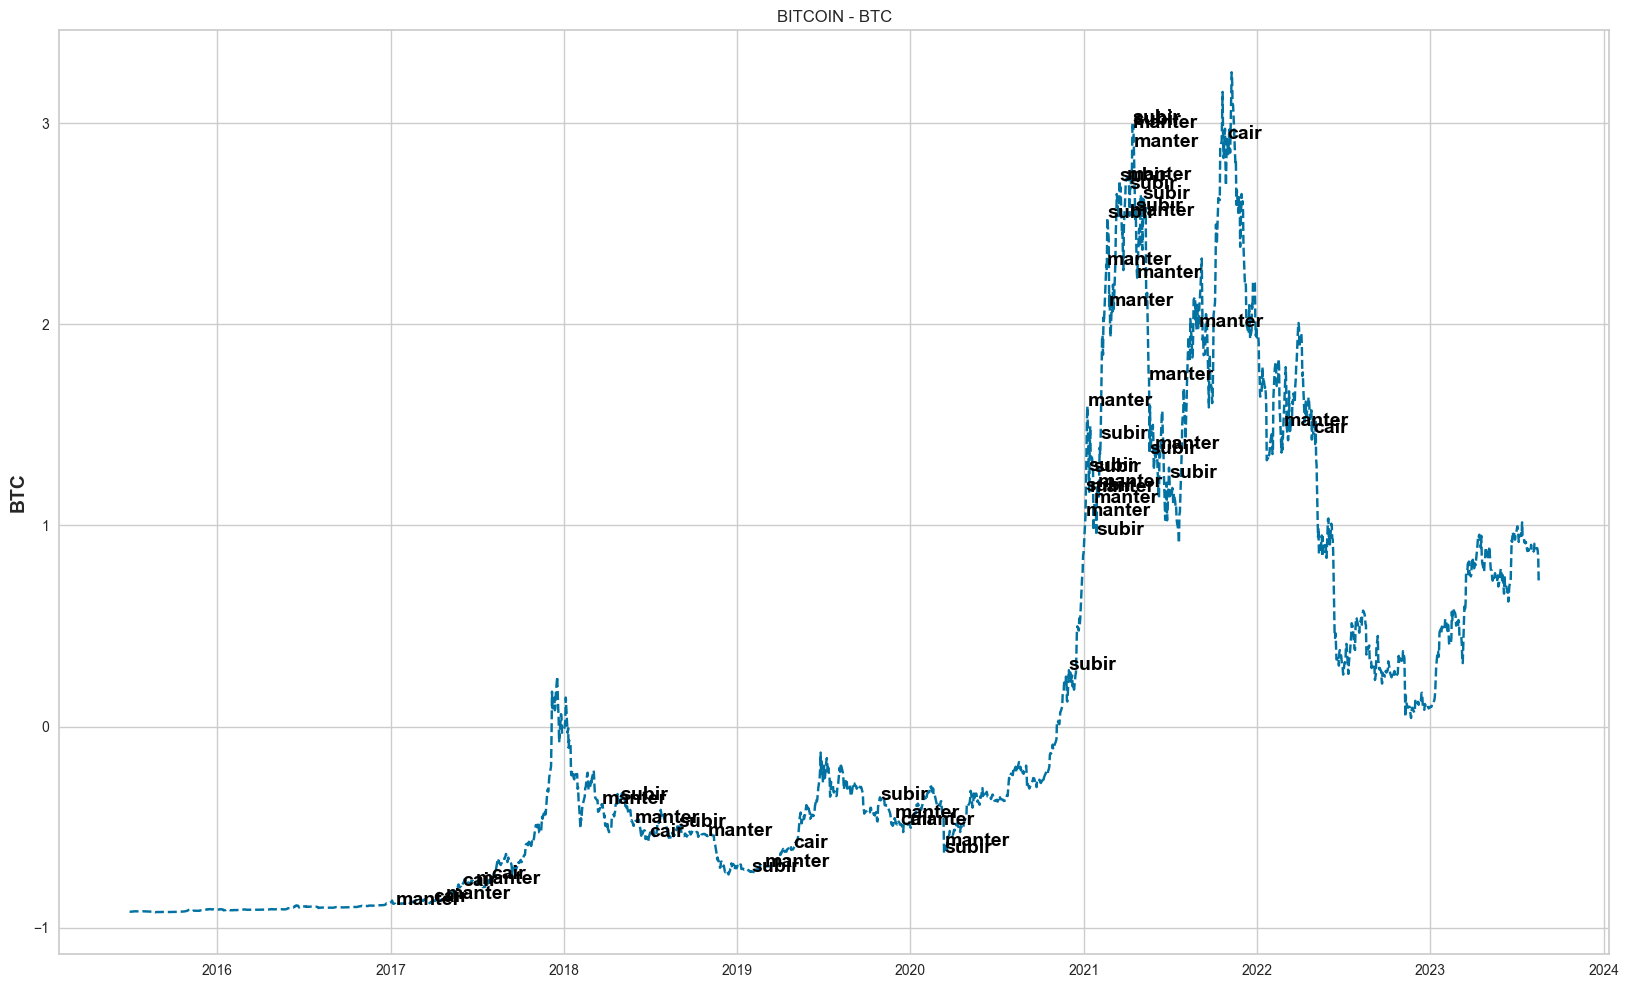

In [228]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot(111)
plt.title("BITCOIN - BTC")

ax1.plot(dfteste.index, dfteste['Close'].values,'--b')
ax1.set_ylabel('BTC', fontsize=14,weight='bold')
for i in range(1, len(decisao_fuzzy)-1):
    if ((decisao_fuzzy.iloc[i] != decisao_fuzzy.iloc[i+1])):
        ax1.text(x=dfteste.index[i], y=dfteste['Close'].values[i], s = str(decisao_fuzzy[i]),rotation=0,fontsize = 14,color='black',weight='bold')
    
# ax2=ax1.twinx()
# ax2.plot(dfteste.index, dfteste["cdi"], label="cdi")
# ax2.plot(dfteste.index, dfteste["ipca"], label="ipca")
# ax2.plot(dfteste.index, dfteste["trendbtc"], label="trendbtc")
# ax2.plot(dfteste.index, dfteste["Volume"], label="Volume")

plt.legend()



plt.show()

In [229]:
sinais = list([])
for i in range(len(decisao_fuzzy)):
    if (decisao_fuzzy.iloc[i] == "subir")&(decisao_fuzzy.iloc[i-1] != decisao_fuzzy.iloc[i]):
        sinais.append(1)
    elif (decisao_fuzzy.iloc[i] =="manter"):
        sinais.append(0)
    elif (decisao_fuzzy.iloc[i] =="cair")&(decisao_fuzzy.iloc[i-1] != decisao_fuzzy.iloc[i]):
        sinais.append(2)
    else:
        sinais.append(0)


In [230]:
df["sinais"] = sinais

In [231]:
ultimo_valor = None

for i in range(len(df)):
    if(df["sinais"].iloc[i] == 1):
        ultimo_valor = df["sinais"].iloc[i]
    elif(df["sinais"].iloc[i-1] == 1)&(df["sinais"].iloc[i] != 2):
        df["sinais"].iloc[i] = ultimo_valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [232]:
for i in range(len(df)):
    if (df["sinais"].iloc[i] == 2):
        df["sinais"].iloc[i] = 1

In [233]:
df["retorno"] = df["Adj Close"].pct_change()

In [234]:
df = df.dropna()

In [235]:
vet_ret = list([])
for i in range(len(df)):
    if (df["sinais"].iloc[i-1] == 1):
        vet_ret.append(df["retorno"].iloc[i])
    elif (df["sinais"].iloc[i-1] == 0):
        vet_ret.append(df["cdi"].iloc[i])


In [236]:
df["estrategia"] = vet_ret

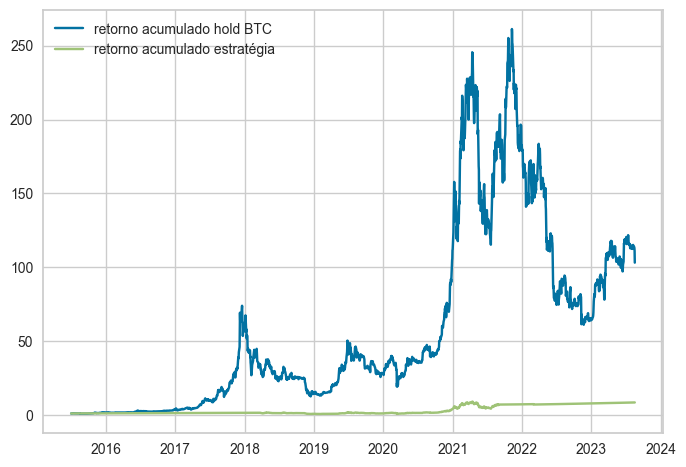

In [237]:
plt.plot(df.index, (df["retorno"]+1).cumprod(), label="retorno acumulado hold BTC")
plt.plot(df.index, (df["estrategia"]+1).cumprod(), label="retorno acumulado estratégia")
plt.legend()
